# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

### Load data 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
import PIL
## import libs
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import gc 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
batch_size = 10

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler =SubsetRandomSampler([k for k in range(100)]),
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

For cifar10, we have $32 \times 32 \times 3  = 3072 $ image dimensions. Hence , the number of dimensions is greater than the number of samples. Furthermore , pixels inputs are usually quite complex and are difficult to model. Therefore, a raw approach can lead to an overfitting problem, since the model won't be able to generalize on 100 samples for 3072 image pixels. 
To fix this issue several methods can be applied : 
* Use pretrained features (for instance on imagenet) and finetune the model on some layers.
* Use data augmentation to increase artificially the number of labeled samples.
* Use self-supervision or weakly supervision models to make use of the unlabeled samples.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
## hyperparameters
lr= 1e-3
dict_results = {}
epochs = 20

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## clear model 
try: 
  for layer in net.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()
  del net
  gc.collect()
except : 
  pass

# Model
print('==> Building model..')
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(512, 10)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr , momentum=0.9)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_score = 100.*correct/total
    print('Train ...')
    print('Loss: %.3f | Acc: %.3f%%'% (train_loss/(batch_idx+1), 100.*correct/total))
    return train_score


def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        test_score = 100.*correct/total
        print('Test ...')
        print('Loss: %.3f | Acc: %.3f%% '
                         % (test_loss/(batch_idx+1),test_score ))
        return test_score

train_scores , test_scores =[],[]
for epoch in range(epochs):
    train_scores.append(train(epoch))
    test_scores.append(test(epoch))
    #scheduler.step()
dict_results['raw']=(train_scores,test_scores)

==> Building model..

Epoch: 0
Train ...
Loss: 2.358 | Acc: 9.000%
Test ...
Loss: 2.324 | Acc: 10.000% 

Epoch: 1
Train ...
Loss: 2.264 | Acc: 16.000%
Test ...
Loss: 2.457 | Acc: 12.390% 

Epoch: 2
Train ...
Loss: 2.194 | Acc: 22.000%
Test ...
Loss: 2.831 | Acc: 15.030% 

Epoch: 3
Train ...
Loss: 2.082 | Acc: 23.000%
Test ...
Loss: 2.729 | Acc: 13.790% 

Epoch: 4
Train ...
Loss: 1.996 | Acc: 29.000%
Test ...
Loss: 2.446 | Acc: 18.140% 

Epoch: 5
Train ...
Loss: 1.896 | Acc: 35.000%
Test ...
Loss: 2.382 | Acc: 17.170% 

Epoch: 6
Train ...
Loss: 1.866 | Acc: 39.000%
Test ...
Loss: 2.279 | Acc: 18.620% 

Epoch: 7
Train ...
Loss: 1.767 | Acc: 44.000%
Test ...
Loss: 2.394 | Acc: 20.830% 

Epoch: 8
Train ...
Loss: 1.692 | Acc: 42.000%
Test ...
Loss: 2.486 | Acc: 19.890% 

Epoch: 9
Train ...
Loss: 1.604 | Acc: 44.000%
Test ...
Loss: 2.362 | Acc: 19.120% 

Epoch: 10
Train ...
Loss: 1.558 | Acc: 41.000%
Test ...
Loss: 2.394 | Acc: 21.510% 

Epoch: 11
Train ...
Loss: 1.407 | Acc: 57.000%
Test ..

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18 100 examples (scratch)  | 20 | 79% | 22.870% |
|   Resnet18 all examples (scratch)  | _ | _ | 93.02% |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4:__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
epochs = 20
batch_size = 10
lr = 1e-3

In [ ]:

try: 
  for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()
  del model
  gc.collect()
except : 
  pass

# fix seed to reproduce results 
torch.manual_seed(1)
model = models.resnet18(pretrained=True)


for k,param in enumerate(model.parameters()):  ## gradient to false
    # here we control the layers that we want to freeze
    '''
    if len(param.shape)>1 : 
      if param.shape[0] == 512 and param.shape[1]==512  :
        print(k)
        break
    '''
    param.requires_grad = False

model.fc = nn.Linear(512, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr , momentum=0.9)

# Training
train_scores , test_scores =[],[]
for epoch in range(epochs):
    train_scores.append(train(epoch))
    test_scores.append(test(epoch))

dict_results['freezed']=(train_scores,test_scores)



Epoch: 0
Train ...
Loss: 2.435 | Acc: 7.000%
Test ...
Loss: 2.511 | Acc: 10.400% 

Epoch: 1
Train ...
Loss: 2.231 | Acc: 21.000%
Test ...
Loss: 2.308 | Acc: 16.920% 

Epoch: 2
Train ...
Loss: 1.961 | Acc: 33.000%
Test ...
Loss: 2.092 | Acc: 26.610% 

Epoch: 3
Train ...
Loss: 1.735 | Acc: 52.000%
Test ...
Loss: 1.994 | Acc: 30.320% 

Epoch: 4
Train ...
Loss: 1.649 | Acc: 51.000%
Test ...
Loss: 1.845 | Acc: 37.870% 

Epoch: 5
Train ...
Loss: 1.495 | Acc: 62.000%
Test ...
Loss: 1.847 | Acc: 34.520% 

Epoch: 6
Train ...
Loss: 1.283 | Acc: 63.000%
Test ...
Loss: 1.760 | Acc: 38.310% 

Epoch: 7
Train ...
Loss: 1.202 | Acc: 75.000%
Test ...
Loss: 1.641 | Acc: 44.160% 

Epoch: 8
Train ...
Loss: 1.049 | Acc: 84.000%
Test ...
Loss: 1.620 | Acc: 44.930% 

Epoch: 9
Train ...
Loss: 0.976 | Acc: 79.000%
Test ...
Loss: 1.567 | Acc: 47.940% 

Epoch: 10
Train ...
Loss: 0.843 | Acc: 92.000%
Test ...
Loss: 1.503 | Acc: 50.430% 

Epoch: 11
Train ...
Loss: 0.865 | Acc: 89.000%
Test ...
Loss: 1.497 | Acc: 

The training was done for a total numbers of epochs of 20. The column "Number of epochs" correspond to the epoch where I've got the best results on test. 
Resnet 18 is composed of four residual blocks. We start by freezing all blocks and train only on the fully connected layer. Then we unfreeze progressively the residual blocks and finally we unfreeze all the model.

| Model | Number of  epochs  | Train accuracy ( 20 epochs) | Test accuracy |
|------|------|------|------|
|   Resnet18 (freezed)  | 18 | 98% | 54.79% |
|   Resnet18 (unfreeze block 4)  | 18 | 100% | 57.29% |
|   Resnet18 (unfreeze blocks 4 and 3 )  | 19 | 100% | 56.77% |
|   Resnet18 (unfreeze blocks 4 , 3 and 2)  | 18 | 100% | 55.7% |
|   Resnet18 (unfreeze blocks 4 , 3 , 2 and 1)  | 19 | 100% | 54.19% |
|   Resnet18 (unfreezed)  | 19 | 100% | 54.01% |

The choice of resnet 18 architecture is due to the small number of labeled data. If we choose bigger architectures such as vgg or resnet 50, the model may probably overfit.

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

Since CIFAR10 images have few pixels $32 \times 32$, augmenting the data directly by incorporating invariance to translation or rotation or scale can lead to poor predictions results, since there is a risk we change completely the content of the image. This may lead to underfitting problem, i.e the model can't learn all the diversity seen in training set. A solution to this is to incrase data size.We can do this for instance by interpolating the pixels to get bigger images. 

## Data augmentations

__Question 6:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [ ]:
import pickle
dict_results = pickle.load(open('/content/drive/MyDrive/data_CS_MVA/ADL/dict_results_tp4.pkl','rb'))

In [ ]:
transform = {'train':transforms.Compose([
    transforms.Resize(256),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR) , 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler =SubsetRandomSampler([k for k in range(100)]),
                                          num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 30
lr = 1e-3

In [ ]:

## clear model 
try: 
  for layer in net.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()
  del net
  gc.collect()
except : 
  pass

# Model
print('==> Building model..')
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(512, 10)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr , momentum=0.9)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

torch.manual_seed(1)
# Training

train_scores , test_scores = [] , []
for epoch in range(epochs):
    train_scores.append(train(epoch))
    test_scores.append(test(epoch))


==> Building model..

Epoch: 0
Train ...
Loss: 2.280 | Acc: 15.000%
Test ...
Loss: 2.317 | Acc: 9.790% 

Epoch: 1
Train ...
Loss: 2.208 | Acc: 18.000%
Test ...
Loss: 2.356 | Acc: 13.240% 

Epoch: 2
Train ...
Loss: 2.167 | Acc: 27.000%
Test ...
Loss: 2.461 | Acc: 12.850% 

Epoch: 3
Train ...
Loss: 2.160 | Acc: 23.000%
Test ...
Loss: 2.570 | Acc: 14.610% 

Epoch: 4
Train ...
Loss: 2.053 | Acc: 27.000%
Test ...
Loss: 2.345 | Acc: 17.740% 

Epoch: 5
Train ...
Loss: 2.010 | Acc: 28.000%
Test ...
Loss: 2.379 | Acc: 18.940% 

Epoch: 6
Train ...
Loss: 1.943 | Acc: 33.000%
Test ...
Loss: 2.354 | Acc: 19.910% 

Epoch: 7
Train ...
Loss: 1.834 | Acc: 40.000%
Test ...
Loss: 2.416 | Acc: 17.200% 

Epoch: 8
Train ...
Loss: 1.780 | Acc: 43.000%
Test ...
Loss: 2.272 | Acc: 19.340% 

Epoch: 9
Train ...
Loss: 1.784 | Acc: 41.000%
Test ...
Loss: 2.290 | Acc: 20.120% 

Epoch: 10
Train ...
Loss: 1.844 | Acc: 37.000%
Test ...
Loss: 2.395 | Acc: 19.030% 

Epoch: 11
Train ...
Loss: 1.755 | Acc: 39.000%
Test ..

| Model | Number of  epochs  | Train accuracy (30 epochs) | Test accuracy |
|------|------|------|------|
|Resnet18 + data augmentation  | 23 | 68% | 24.49% |

In [ ]:
dict_results['augmented']=(train_scores,test_scores)
pickle.dump(dict_results,open('/content/drive/MyDrive/data_CS_MVA/ADL/dict_results_tp4.pkl','wb'))

# Conclusions

__Question 7:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In this work , I explored several ways to handle the data shortage. The first method , which is the "naive" one, consists of training from scratch the model on the labeled data. The advantage of this approach is that it is straightforward and don't necessit any extra knowledge. But the model overfits easily on the labeled data and this what explains the huge gap between train and test accuracy. 

A more intelligent approach is to use a pretrained model to extract relevant features and then finetune the model on one or multiple layers. Our best results on test correspond to the freezing of all layers except the last one. In fact , the first layers extract genral features such as edges , contours,etc... and the deeper the layers , the deeper the model becomes "task specific". So freezing first layers and finetuning the last ones makes sense. The disadvantage of this method is that we need pretrained models on thousands or millions of examples to construct relevant features for many other tasks.
The last method that we tried is data augmentation. This improves slightly the results on the raw model. The advantage is that by simple data transformations, we manage to increase efficiently the number of labeled examples.


In the next cell you can see a comparison between the different methods  that we tried. The curves labeled by "freezed" or "unfreezed" denote the pretrained resnet 18 model that we finetune on our subset of 100 samples.  

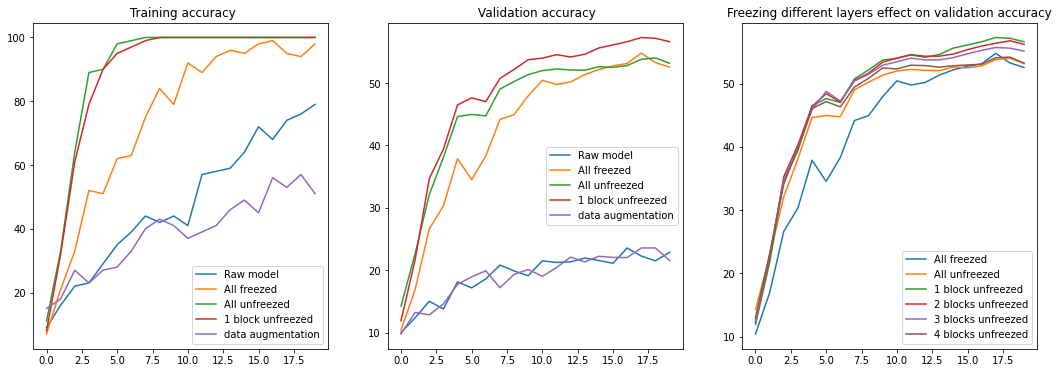

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3, figsize=(18,6))

ax[0].plot(dict_results['raw'][0],label = 'Raw model')
ax[0].plot(dict_results['freezed'][0],label = 'All freezed')
ax[0].plot(dict_results['unfreezed'][0][:20],label = 'All unfreezed')
ax[0].plot(dict_results['1 block unfr '][0],label = '1 block unfreezed')
ax[0].plot(dict_results['augmented'][0][:20],label = 'data augmentation')
ax[0].set_title(' Training accuracy')
ax[0].legend()


ax[1].plot(dict_results['raw'][1],label = 'Raw model')
ax[1].plot(dict_results['freezed'][1],label = 'All freezed')
ax[1].plot(dict_results['unfreezed'][1],label = 'All unfreezed')
ax[1].plot(dict_results['1 block unfr '][1],label = '1 block unfreezed')
ax[1].plot(dict_results['augmented'][1][:20],label = 'data augmentation')
ax[1].set_title(' Validation accuracy')
ax[1].legend()


ax[2].plot(dict_results['freezed'][1],label = 'All freezed')
ax[2].plot(dict_results['unfreezed'][1],label = 'All unfreezed')
ax[2].plot(dict_results['1 block unfr '][1],label = '1 block unfreezed')
ax[2].plot(dict_results['2 blocks unfr'][1],label = '2 blocks unfreezed')
ax[2].plot(dict_results['3 blocks unfr'][1],label = '3 blocks unfreezed')
ax[2].plot(dict_results['4 blocks unfr'][1],label = '4 blocks unfreezed')
ax[2].set_title('Freezing different layers effect on validation accuracy')
ax[2].legend()

We can see that freezing the pretraining model and finetuning on the last resnet block outperforms the rest of the models. Also data augmentation improves the model from scratch so it can be a good alternative if don't have unlabeled data to pretrain the model on. 

# Weak supervision

__Bonus (Open) Question:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

**Proposed weak supervision method**: <br>
We use a self-supervised Learning approach. We define a separate task using the unlabelled data; the goal is to learn useful features from the unlabelled images that will help in the classification task. <br>
We use the task of predicting image rotations. We transform each unlabelled image into 4 rotated images (by an angle of 90 degrees), and then we train the model to predict the rotations. The main idea behind this approach, is that in order to correctly predict the angle of the rotation, the models needs to learn good feature representation of the image which will be useful for the next classifcation task. <br>
After that, we finetune the previously trained model on the small labeled dataset for the classification task.

**Rotation prediction Task**

In [ ]:
img_size = 32
batch_size = 64
num_workers = 2
lr = 0.001

In [ ]:
class RotationDataset(Dataset):
    
    def __init__(self, split, preTransform=None, postTransform = None):
        #self.root_dir = root_dir
        
        #Output of pretransform should be PIL images
        self.preTransform = preTransform
        
        self.postTransform = postTransform
        self.split = split
        self.dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=self.preTransform)    

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img0,clss = self.dataset[idx]
        
        rot_class = np.random.randint(4)
        rot_angle = rot_class * 90

        rot_img = img0.rotate(rot_angle)
        if self.postTransform:
            sample = self.postTransform(rot_img)
        else:
            sample = transforms.ToTensor(rot_img)
        
        return sample, rot_class

- Below is a visualization of a batch of training data with rotated images

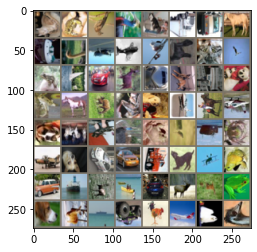

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)


out = out.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
out = std * out + mean
out = np.clip(out, 0, 1)
plt.imshow(out)

In [ ]:
#Define dataloaders

data_pre_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
    ]),
}

data_post_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

image_datasets = {x: RotationDataset(x,  data_pre_transforms[x], data_post_transforms[x]) for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size,
                                              shuffle=True, num_workers=num_workers)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

if torch.cuda.is_available() and not is_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda:0" if is_cuda else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define Model
print('==> Building model..')
net = models.resnet34(pretrained=True)
net.fc = nn.Linear(512, 4)
net = net.to(device)

for param in net.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.005)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

torch.manual_seed(22)

trainloader = dataloaders["train"]
testloader = dataloaders["val"]

# Training
train_scores , test_scores = [] , []
for epoch in range(25):
    train_scores.append(train(epoch))
    test_scores.append(test(epoch))
    scheduler.step()

==> Building model..

Epoch: 0
Train ...
Loss: 0.910 | Acc: 60.624%
Test ...
Loss: 0.700 | Acc: 71.538% 

Epoch: 1
Train ...
Loss: 0.680 | Acc: 72.934%
Test ...
Loss: 0.601 | Acc: 76.254% 

Epoch: 2
Train ...
Loss: 0.602 | Acc: 76.448%
Test ...
Loss: 0.531 | Acc: 79.422% 

Epoch: 3
Train ...
Loss: 0.551 | Acc: 78.750%
Test ...
Loss: 0.497 | Acc: 80.704% 

Epoch: 4
Train ...
Loss: 0.516 | Acc: 80.134%
Test ...
Loss: 0.460 | Acc: 82.506% 

Epoch: 5
Train ...
Loss: 0.485 | Acc: 81.352%
Test ...
Loss: 0.438 | Acc: 83.190% 

Epoch: 6
Train ...
Loss: 0.464 | Acc: 82.408%
Test ...
Loss: 0.415 | Acc: 84.370% 

Epoch: 7
Train ...
Loss: 0.438 | Acc: 83.404%
Test ...
Loss: 0.392 | Acc: 85.144% 

Epoch: 8
Train ...
Loss: 0.417 | Acc: 84.154%
Test ...
Loss: 0.383 | Acc: 85.552% 

Epoch: 9
Train ...
Loss: 0.407 | Acc: 84.554%
Test ...
Loss: 0.366 | Acc: 86.240% 

Epoch: 10
Train ...
Loss: 0.392 | Acc: 85.190%
Test ...
Loss: 0.353 | Acc: 86.806% 

Epoch: 11
Train ...
Loss: 0.382 | Acc: 85.720%
Test .

| Model | Number of  epochs  | Train accuracy (30 epochs) | Test accuracy |
|------|------|------|------|
|Resnet34 trained on proxy task (rotation prediction)  | 24 | 90.046% | 91.192% |

**Finetune on the classification Task**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#loader to load the 100 trained labeled samples
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          sampler =SubsetRandomSampler([k for k in range(100)]),
                                          num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Change the fully connected layer, we have 10 classes now instead of 4
net.fc = nn.Linear(512, 10)

In [ ]:
net = net.to(device)

In [ ]:
#Unfreezing only the last conv layer
for param in net.parameters():
    param.requires_grad = False
for param in net.layer4.parameters():
    param.requires_grad = True
for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
params_tofit = filter(lambda p: p.requires_grad, net.parameters())
optimizer = optim.SGD(params_tofit, lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#Training
train_scores , test_scores =[],[]
for epoch in range(25):
    train_scores.append(train(epoch))
    test_scores.append(test(epoch))
    scheduler.step()


Epoch: 0
Train ...
Loss: 2.380 | Acc: 11.000%
Test ...
Loss: 2.326 | Acc: 10.800% 

Epoch: 1
Train ...
Loss: 2.199 | Acc: 18.000%
Test ...
Loss: 2.260 | Acc: 14.020% 

Epoch: 2
Train ...
Loss: 2.057 | Acc: 25.000%
Test ...
Loss: 2.203 | Acc: 18.560% 

Epoch: 3
Train ...
Loss: 1.967 | Acc: 42.000%
Test ...
Loss: 2.171 | Acc: 21.730% 

Epoch: 4
Train ...
Loss: 1.741 | Acc: 45.000%
Test ...
Loss: 2.149 | Acc: 23.660% 

Epoch: 5
Train ...
Loss: 1.575 | Acc: 53.000%
Test ...
Loss: 2.096 | Acc: 26.570% 

Epoch: 6
Train ...
Loss: 1.549 | Acc: 64.000%
Test ...
Loss: 2.065 | Acc: 27.950% 

Epoch: 7
Train ...
Loss: 1.333 | Acc: 74.000%
Test ...
Loss: 2.074 | Acc: 28.280% 

Epoch: 8
Train ...
Loss: 1.462 | Acc: 73.000%
Test ...
Loss: 2.083 | Acc: 28.000% 

Epoch: 9
Train ...
Loss: 1.322 | Acc: 76.000%
Test ...
Loss: 2.067 | Acc: 28.570% 

Epoch: 10
Train ...
Loss: 1.414 | Acc: 73.000%
Test ...
Loss: 2.077 | Acc: 28.560% 

Epoch: 11
Train ...
Loss: 1.271 | Acc: 75.000%
Test ...
Loss: 2.072 | Acc:

| Model | Number of  epochs  | Train accuracy (30 epochs) | Test accuracy |
|------|------|------|------|
|Resnet34 finetuned  | 24 | 71% | 29.11% |

**Remarks**:
- Using a self-supervised approach yields better results (29.11% test acc) compared to training from scratch (22.86% test accuracy).
- However transfer learning is still way better (around 54% test accuracy). In fact, the features learned from pretraining on ImageNet seem to be better than those learned from the chosen proxy task (predciting image rotations)